##  SLIC Superpixels computation

In [1]:
import math
from skimage import io, color, data
from skimage.transform import rescale
import numpy as np
import matplotlib.pyplot as plt

### PART 1 Skimage implementation  
Here we get a glimpse of SLIC, as we change the number of segments
You may check out the `skimage.segmentation.slic` documentation to understand the meaning of the other parameters (eg compactness)

In [2]:
#image =data.astronaut()
filename="C://Users//Pishro System///due.jpg"
image = io.imread(filename)

In [ ]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage.segmentation._slic import _enforce_label_connectivity_cython

#COMMENTS:

#CHANGING COMPACTNESS: first of all I altered the value of compactness and what I observes is that for the higher values of compactness
# We will have superpixels with square shape.According to the documentation, higher values of compactness indicate that
# We consider that pixels that are next to each other are in a single superpixel while if we use smaller value for 
# Compactness (for example 0.1), we will have super pixels that are similar in terms of color not location. Foe instance 
# By using 0.1 we can see that in a single petal of flower we have many layered superpixels that are belong to the areas with
# Similar color tone.


#CHANGING SIGMA: in this part we are applying a low pass filter on our input image before doing segmentation. As it might expected
#By applying a higher smoothing on our image, the details were disappear so for smoother images, we can obviously see that
# The number of superpixels in an area will reduce. This might be the case because in the smooth image, the nearby areas 
# Become similar to each other as we cut the detail of the image by applying gaussian so we will have lower number of superpixel.
#This senario is vise versa when we have higher sigma values and as a result we have more high frequency detail components.


for numSegments in (50,100,150,200): # select different values
    segments = slic(image, n_segments = numSegments, sigma =10,compactness=15)
    
    fig = plt.figure("Superpixels -- %d segments" % (numSegments))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(mark_boundaries(image, segments, color=(0,0,1),mode='thick'))
    plt.axis("off")
# show the plots
plt.show()

###  <font color="blueviolet">Analysis and Comments:  <font color="navy">  In the below I put image of the flowers with sigma =20 and sigma 1 in order to make a comparison and get the result that I mentioned above in the code:
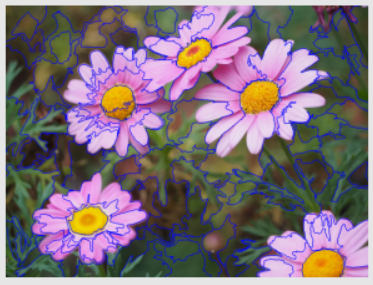
 ### <center><font color="navy"> Sigma=1</center>

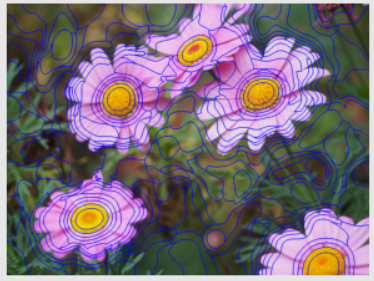
### <center><font color="navy">Sigma=20</center>

### <font color="navy"> In addition below are the result of the changing the COMPACTNESS factor:
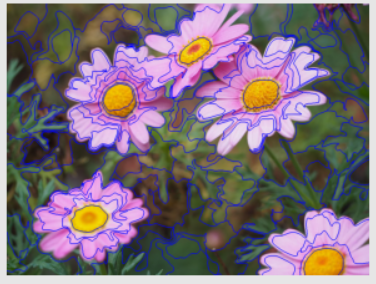
### <center><font color="navy"> Compactness=0.1</center>

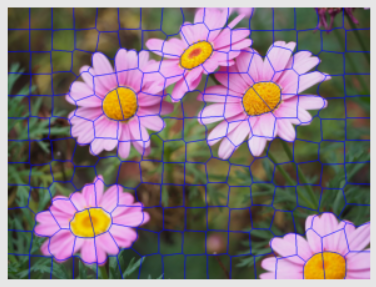
### <center><font color="navy"> Compactness=100</center>

### PART 2 - Having a look  inside an implementation
Refer to  <a href="https://www.iro.umontreal.ca/~mignotte/IFT6150/Articles/SLIC_Superpixels.pdf"  > the original paper </a>  



In [16]:
class Cluster(object):
    cluster_index = 1

    def __init__(self, h, w, l=0, a=0, b=0):
        
        self.pixels = []
        self.no = self.cluster_index
        Cluster.cluster_index += 1
        self.h = h
        self.w= w
        self.l=l
        self.a=a
        self.b=b
        

    def update(self, h, w, l, a, b):
        #compute the residual error
        self.e = np.sqrt(np.sum((np.array([h, w, l, a, b]) - np.array([self.h, self.w, self.l,self.a, self.b]))**2))
        self.h = h
        self.w = w
        self.l = l
        self.a = a
        self.b = b
        

class SLICProcessor(object):
   
    def __init__(self, img, num_segments = 10, M=20,max_iter = 10,error_threshold=10, verbose=True):
        self.K = num_segments
        self.M = M
        self.max_iter = max_iter
        
        self.data = color.rgb2lab(img) #the image converted to lab space
        self.image_height = self.data.shape[0] #image rows
        self.image_width = self.data.shape[1] #image cols
        self.N = self.image_height * self.image_width #pixel number
        
        self.S = int(math.sqrt(self.N / self.K)) #segment side
        self.error_threshold = error_threshold
        self.clusters = []
        self.label = {}
        self.dis = np.full((self.image_height, self.image_width), np.inf)
        # verbose regulates the printing of the error after every iteration
        self.verbose = verbose
        
    #create and return an object cluster
    def make_cluster(self, h, w):
        
        h = int(h)
        w = int(w)
        return Cluster(h, w,
                       self.data[h][w][0],
                       self.data[h][w][1],
                       self.data[h][w][2])

        
    #place initial clusters at the center of each initial segment
    def init_clusters(self):
        # start so that the first cluster is on the top left corner
        curr_h = int(self.S / 2)
        curr_w = int(self.S / 2)
        
        while curr_h < self.image_height:
            while curr_w < self.image_width:
                self.clusters.append(self.make_cluster(curr_h, curr_w))
                
                curr_w += self.S    # next cluster will be S elements away
            
            # once we iterated over the whole width of the image we have to:
            # go back to the left
            curr_w = int(self.S / 2)
            # go S element "down"
            curr_h += self.S       
                
    #get gradient at point h,w
    def get_gradient(self, h, w):
        
        if w + 1 >= self.image_width:
            w = self.image_width - 2
        if h + 1 >= self.image_height:
            h = self.image_height - 2
        
        gradient_x = np.sum(self.data[h][w] - self.data[h+1][w])
        gradient_y = np.sum(self.data[h][w] - self.data[h][w+1])
        
        gradient = np.sqrt(gradient_x**2 + gradient_y**2)
         
        return gradient

    #adjust cluster center on low gradient points ( move to smaller gradient)
    def move_clusters(self):
        
        for cluster in self.clusters:
            cluster_gradient = self.get_gradient(cluster.h, cluster.w)
            #### locate minimum gradient in 3x3 area around the current cluster center
            min_i = 0
            min_j = 0
            for i in range(-1,2):
                for j in range(-1,2):
                    # if the 3x3 area of our cluster was to fall outside the image skip that position
                    if cluster.h + i < 0 or cluster.h + i >= self.image_height or cluster.w + j < 0 or cluster.w + j >= self.image_width:
                        continue
                    curr_gradient = self.get_gradient(cluster.h+i, cluster.w + j)                    
                    if curr_gradient < cluster_gradient:
                        # UPDATE appropriate variables
                        min_i=i
                        min_j=j
            
            # move cluster in point with smallest gradient
            # if it was already in the best spot we just move it by 0 pixels
            new_h = cluster.h + min_i
            new_w = cluster.w + min_j
            # doesn't matter that here we compute the residual error since in
            # process we perform at least one iteration
            # this allows us to keep the previous indexing
            cluster.update(new_h, new_w, self.data[new_h][new_w][0], self.data[new_h][new_w][1], self.data[new_h][new_w][2])
           
    
    #assign pixels to nearest cluster using the proposed distance in labxy space
    def assignment(self):
        
        for cluster in self.clusters:
            for h in range(cluster.h - 2 * self.S, cluster.h + 2 * self.S):
                if h < 0 or h >= self.image_height: continue
                for w in range(cluster.w - 2 * self.S, cluster.w + 2 * self.S):
                    if w < 0 or w >= self.image_width: continue
                    L, A, B = self.data[h][w]
                    #compute the distance in 5d space (see Eq (1) of the paper)
                    D_xy = np.sqrt((cluster.h - h)**2 + (cluster.w - w)**2)
                    D_lab =  np.sqrt((cluster.l - L)**2 + (cluster.a - A)**2 + (cluster.b - B)**2) 
                    D = np.sqrt(D_lab**2 + (D_xy / self.S)**2 * self.M**2)
                    
                    if D < self.dis[h][w]:
                        if (h, w) not in self.label:
                            #if not yet assigned
                            self.label[(h,w)] = cluster
                            cluster.pixels.append((h,w))    # add current pixel to the list of pixels of its nearest cluster
                        else:
                            # re-assign
                            # this pixel already has a label, meaning that it can be found in
                            # the pixel list of its current cluster
                            # before updating remove it
                            self.label[(h,w)].pixels.remove((h,w))
                            self.label[(h,w)] = cluster
                            cluster.pixels.append((h,w))
                        #update new distance
                        self.dis[h][w] = D
                        
                     
    #update clusters centers using the average of member pixels
    def update_cluster(self):
        for cluster in self.clusters:
            sum_h = sum_w = number = 0
            for p in cluster.pixels:
                sum_h += p[0]
                sum_w += p[1]
            
            number = len(cluster.pixels)
            _h = int(sum_h / number)
            _w = int(sum_w / number)
            # place the cluster center at the centroid
            cluster.update(_h, _w, self.data[_h][_w][0], self.data[_h][_w][1], self.data[_h][_w][2])

    #get class membership per pixel
    def get_boundaries(self):
        
        image_arr = np.zeros((self.image_height,self.image_width),int)
        index = 0
        for cluster in self.clusters:
            for p in cluster.pixels:
                image_arr[p[0]][p[1]] = index
            index+=1
        return image_arr
    
   #algorithm steps
    def get_residual_error(self):
        tot_e = 0
        for cluster in self.clusters:
            tot_e += cluster.e
        return tot_e
    
    
    def process(self):        
        self.init_clusters()
        self.move_clusters()
        for i in range(self.max_iter):
            self.assignment()
            self.update_cluster()
            
            error = self.get_residual_error()
            if self.verbose:
                print('Iteration %d, residual error E= %f' % (i,error))
            if(error<1.0):
                break
            
        return self.get_boundaries()

   

### Let's test the implementation
you may want to measure the time and compare to python's version

In [31]:
# here I'm cropping the image to reduce the execution time
img2  = io.imread("C://Users//Pishro System///mandrill.jpg")
[row,col,c]=np.shape(img2)
img2_crop = img2[:row//2,:col//2,:]
print(np.shape(img2_crop))

(128, 128, 3)


In [47]:
p = SLICProcessor(img2_crop, num_segments = 20, M=60, max_iter = 10)
boundaries = p.process()

Iteration 0, residual error E= 438.844963
Iteration 1, residual error E= 238.426907
Iteration 2, residual error E= 203.245380
Iteration 3, residual error E= 106.342994
Iteration 4, residual error E= 15.903125
Iteration 5, residual error E= 7.956455
Iteration 6, residual error E= 0.000000


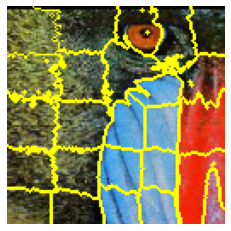

In [48]:
# visualize
fig = plt.figure("Superpixels -- %d segments" % (10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(mark_boundaries(img2_crop, boundaries))
plt.axis("off")

plt.show()

###  <font color="blueviolet">Analysis and Comments: <font color="navy"> By choosing a proper M, our algorithm will be able to detect boundaries of two distinct areas better.

 
What if we apply a low pass filter first?

In [51]:
from skimage import filters
sigma = np.sqrt(2)
Ig_smooth = filters.gaussian(img2_crop, sigma);

<ipython-input-51-ae2805182c4b>:3: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  Ig_smooth = filters.gaussian(img2_crop, sigma);


In [52]:
p = SLICProcessor(Ig_smooth, num_segments = 20, M=60, max_iter = 10)
boundaries = p.process()

Iteration 0, residual error E= 267.044886
Iteration 1, residual error E= 102.577441
Iteration 2, residual error E= 42.458343
Iteration 3, residual error E= 46.807694
Iteration 4, residual error E= 4.391883
Iteration 5, residual error E= 0.000000


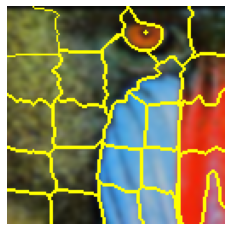

In [53]:
# visualize
fig = plt.figure("Superpixels -- %d segments" % (10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(mark_boundaries(Ig_smooth, boundaries))
plt.axis("off")

plt.show()

###  <font color="blueviolet">Analysis and Comments:  <font color="navy">  As far as I can see by applying a low pass filter our image get smoother and as a result we miss some details and the boundaries become more similar to each other and as it can be seen from above image ( specially compared to the same image segmentation result without smoothing) we can say that we will have smooth and curve segmantation lines with low pass filter result. Also some details that algorithm captured are disappeared and they all considered as a unit segment of our image.